# CTA data analysis with Gammapy

## Introduction

The CTA observatory has started to release first Instrument Function Responses (IRF) and internally proceed to a first data challenge ("CTA 1DC") with lastest IRFs, focusing on high-level data analysis. Gammapy is a prototype for the CTA science tools (see Gammapy proceeding from ICRC 2017), and while many things are work in progress (most importantly: source and background modeling and cube analysis), you can use it already to analyse the simulated CTA data.

The latest IRFs that have been released can be found here: https://www.cta-observatory.org/science/cta-performance/

### This tutorial notebook

This notebook shows you how to get started with some simulated CTA data and what it contains.

You will learn how to use Astropy and Gammapy to:

 - access event data
 - access instrument response functions (IRFs)
 - use index files and the gammapy.data.DataStore to access all data
 - use the observation index file to select the observations you're interested in

This is to familiarise ourselves with the data files and to get an overview.

### Further information

How to analyse the CTA 1DC data with Gammapy (make an image and spectrum) is shown in the next notebooks. If you prefer, you can of course just skim or skip this notebook and go straight to the others.

More tutorial notebooks for Gammapy are here, the Gammapy Sphinx docs are at at http://docs.gammapy.org. If you have a Gammapy-related question, please send an email to to Gammapy mailing list at http://groups.google.com/group/gammapy (registration required) or if you have an issue or feature request, file an issue here: https://github.com/gammapy/gammapy/issues/new (free Github account required, takes 1 min to set up).


## Notebook and Gammapy Setup

Before we get started, please execute the following code cells.

The first one configures the notebooks, so that plots are shown inline (if you don't do this, separate windows will pop up). The second cell imports and checks the version of the packages we will use below. If you're missing some packages, install them and then select "Kernel -> Restart" above to restart this notebook.

In case you're new to Jupyter notebooks: to execute a cell, select it, then type "SHIFT" + "ENTER".


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
import gammapy

print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('gammapy:', gammapy.__version__)

('numpy:', '1.11.2')
('astropy:', u'1.3.3')
('gammapy:', u'0.7.dev5070')



## Getting the tutorial data¶

When installing this notebook on your local machine, you have downloaded at the same time the simulated CTA data!

There are in our downloaded directory of *gammapy-meudon-tutorial*, under the name *handson*. Overall it's quite light (217 MB). These data are a mini-simulation of the Galactic Plane using public IRFS (as mentionned above, the so-called *Prod2*) and a Galaxy modelization using the Kashiwa model **??**, only around the Carena arm over 60deg wide, using 122 CTA array pointings over 3 rows. Here is a sky image:
![Used simulated data](img/lgieihoepmcjomfg.png)

While you wait, we strongly recommend you go over some CTA basics as well as some Python basics to prepare yourself for this tutorial.

Got the data?


In [3]:
!echo $CTADATA

/home/bruno/MesProgrammes/gammapy-meudon-tutorial/handson


In [5]:
!ls $CTADATA

caldb  data  index  models  obs




A very detailed specification of the data formats is here: http://gamma-astro-data-formats.readthedocs.io/

But actually, instead of reading those pages, let's just explore the data and see how to load it with Gammapy ...

Before we start, you should have the CTADATA environment variable pointing to the folder where all data is located:
 - you either have to exit the "jupyter notebook" command on your terminal, set the environment variable (I'm using bash and added the command export CTADATA=[Directory of gammapy-meudon-tutorial]/handson to my ~/.profile file and then did source ~/.profile), then re-start Jupyter and this notebook.
 - or you can set the environment variable by uncommentting the code in the following cell, setting the correct path, then executing it.

In [6]:
# import os
# os.environ['CTADATA'] = '[Directory of gammapy-meudon-tutorial]/handson'
# !echo $CTADATA
# !ls $CTADATA


## Overview of simulated data files

Let's have a look around at the directories and files in $CTADATA.

We will look at the data folder with events, the caldb folder with the IRFs and the index folder with the index files. At the end, we will also mention what the model and obs folder contains, but they aren't used with Gammapy, at least not at the moment.

### EVENT data

First, the EVENT data (RA, DEC, ENERGY, TIME of each photon or hadronic background event) is in the data/baseline folder, with one observation per file. The "baseline" refers to the assumed CTA array that was used to simulate the observations. The number in the filename is the observation identifier OBS_ID of the observation. Observations are ~ 30 minutes, pointing at a fixed location on the sky.

In [7]:
!ls $CTADATA

caldb  data  index  models  obs


In [8]:
!ls $CTADATA/data

gps		 obs_110030.fits  obs_110061.fits  obs_110092.fits
obs_110000.fits  obs_110031.fits  obs_110062.fits  obs_110093.fits
obs_110001.fits  obs_110032.fits  obs_110063.fits  obs_110094.fits
obs_110002.fits  obs_110033.fits  obs_110064.fits  obs_110095.fits
obs_110003.fits  obs_110034.fits  obs_110065.fits  obs_110096.fits
obs_110004.fits  obs_110035.fits  obs_110066.fits  obs_110097.fits
obs_110005.fits  obs_110036.fits  obs_110067.fits  obs_110098.fits
obs_110006.fits  obs_110037.fits  obs_110068.fits  obs_110099.fits
obs_110007.fits  obs_110038.fits  obs_110069.fits  obs_110100.fits
obs_110008.fits  obs_110039.fits  obs_110070.fits  obs_110101.fits
obs_110009.fits  obs_110040.fits  obs_110071.fits  obs_110102.fits
obs_110010.fits  obs_110041.fits  obs_110072.fits  obs_110103.fits
obs_110011.fits  obs_110042.fits  obs_110073.fits  obs_110104.fits
obs_110012.fits  obs_110043.fits  obs_110074.fits  obs_110105.fits
obs_110013.fits  obs_110044.fits  obs_110075.fits  obs_110106.fits
obs_11

In [9]:
!ls $CTADATA/data/gps | head -n3

obs_110000.fits
obs_110001.fits
obs_110002.fits


In [10]:
# There's 123 observations and 4 KB of event data for this min Galactic Plane survey
!ls $CTADATA/data/gps | wc -l
!du -hs $CTADATA/data/gps

123
4,0K	/home/bruno/MesProgrammes/gammapy-meudon-tutorial/handson/data/gps



Let's open up the first event list using the Gammapy EventList class, which contains the EVENTS table data via the table attribute as an Astropy Table object.


In [11]:
from gammapy.data import EventList
events = EventList.read('$CTADATA/data/gps/obs_110029.fits')
print(type(events))
print(type(events.table))

<class 'gammapy.data.event_list.EventList'>
<class 'astropy.table.table.Table'>


In [12]:
# First event (using [] for "indexing")
events.table[0]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,662880013.157,152.149,-57.0389,0.0460746,1.09913,-0.892602,2


In [13]:
# First few events (using [] for "slicing")
events.table[:2]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,662880013.157,152.149,-57.0389,0.0460746,1.09913,-0.892602,2
2,662880015.654,152.323,-56.5967,0.0594762,1.54337,-0.807742,2


In [14]:
# Event times can be accessed as Astropy Time objects
print(type(events.time))

<class 'astropy.time.core.Time'>


In [15]:
events.time[:2]

<Time object: scale='tt' format='mjd' value=[ 59216.7223745  59216.7224034]>

In [16]:
# Convert event time to more human-readable format
print(events.time[:2].fits)

['2021-01-02T17:20:13.157(TT)' '2021-01-02T17:20:15.654(TT)']


In [17]:
# Event positions can be accessed as Astropy SkyCoord objects
print(type(events.radec))
events.radec[:2]

<class 'astropy.coordinates.sky_coordinate.SkyCoord'>


<SkyCoord (ICRS): (ra, dec) in deg
    [( 152.1491394 , -57.03885651), ( 152.32264709, -56.59669876)]>

In [18]:
events.galactic[:2]

<SkyCoord (Galactic): (l, b) in deg
    [( 282.14433029, -0.8906847), ( 281.96547424, -0.4753137)]>

In [19]:
# The event header information is stored
# in the `events.table.meta` dictionary
print(type(events.table.meta))
# E.g. to get the observation pointing position in degree:
events.table.meta['RA_PNT'], events.table.meta['DEC_PNT']

<class 'collections.OrderedDict'>


(153.78979492, -58.1488)


## EVENT analysis example

As an example how to work with EVENT data, let's look at the spatial and energy distribution of the events for a single run.

Note that EVENT data in Gammapy is just stored in an Astropy Table, which is basically a dictionary mapping column names to column data, where the column data is a Numpy array. This means you can efficienly process it from Python using any of the scientific Python tools you like (e.g. Numpy, Scipy, scikit-image, scikit-learn, ...)

### EVENT spatial distribution

To illustrate a bit how to work with EVENT table an header data, let's plot the event positions as well as the pointing position.


<SkyCoord (Galactic): (l, b) in deg
    ( 283.50003858, -1.30002226)>

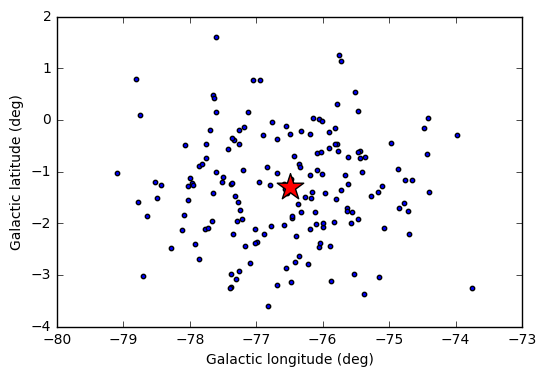

In [20]:
# Event positions
pos = events.galactic[::300] # sub-sample every 100th event
plt.scatter(pos.l.wrap_at('180 deg').deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(pos_pnt.l.wrap_at('180 deg').deg, pos_pnt.b.deg,
            marker='*', s=400, c='red')
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Galactic latitude (deg)')
pos_pnt


### EVENT energy distribution

Let's have a look at the event energy distribution.


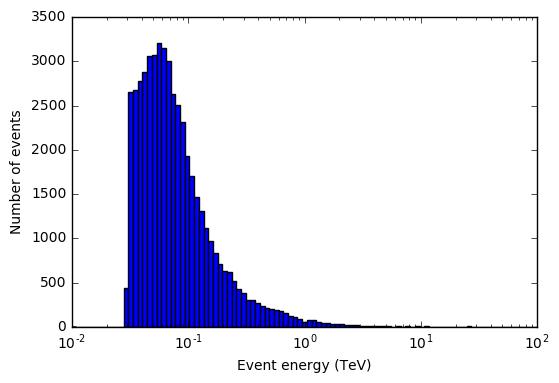

In [21]:
energy = events.table['ENERGY'].data
energy_bins = np.logspace(-2, 2, num=100)
plt.hist(energy, bins=energy_bins)
plt.semilogx()
plt.xlabel('Event energy (TeV)')
plt.ylabel('Number of events')

This events distribution is in fact the superposition of the simulated gamma-rays and residual background events (electrons and protons) surviving the cuts used to enrich the S/N ratio .... let's try to find out what are the gammas and gamma-like background ...

### EVENT MC_ID

One idea could be to split the data into gamma-ray and hadronic background events. Now from looking at the FITS header, one can see that MC_ID == 1 is the hadronic background, and the other values are for different gamma-ray emission components.


In [22]:
is_gamma = events.table['MC_ID'] != 1
print('Number of events: ', len(events.table))
print('Number of gammas: ', is_gamma.sum())
print('Number of hadrons: ', len(events.table) - is_gamma.sum())

('Number of events: ', 50044)
('Number of gammas: ', 1148)
('Number of hadrons: ', 48896)


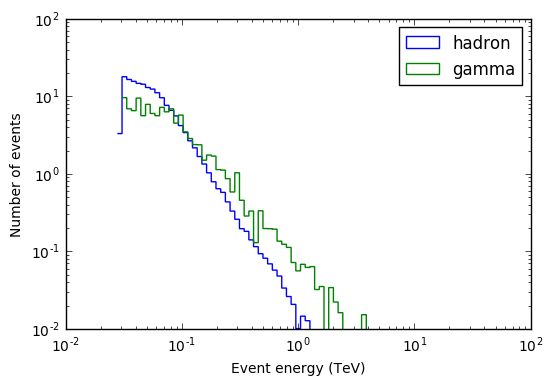

In [23]:
energy = events.table['ENERGY'].data
energy_bins = np.logspace(-2, 2, num=100)
opts = dict(bins=energy_bins, normed=True, histtype='step')
plt.hist(energy[~is_gamma], label='hadron', **opts)
plt.hist(energy[is_gamma], label='gamma', **opts)
plt.loglog()
plt.xlabel('Event energy (TeV)')
plt.ylabel('Number of events')
plt.legend()


When plotting in log-log, one can see that the spectra are roughly power-laws (as expected), and below 100 GeV the signal to background ratio is lower.

What we're seeing here is the result of a mixed-array in CTA with LSTs, MSTs and SSTs, which have different energy thresholds:

 - ~ 30 GeV is the energy threshold of the LSTs
 - ~ 100 GeV is the energy threshold of the MSTs
 - the energy threshold of the SSTs is at a few TeV and doesn't show up as a clear feature because of the too small number of simulated events.

Let's look a little deeper and also check the event offset distribution in the field of view ...

### EVENT FOV offset

The event position and offset in the field of view (FOV) can be computed from the event RA, DEC position and the observation pointing RA, DEC position.

But actually, the field of view position is stored as extra columns in the EVENT list: DETX and DETY (angles in degree, I think RA / DEC aligned field of view system).

I presume (hope) this unnecessary information will be dropped from the CTA event lists in the future to save some space (make the CTA DL3 data ~25% smaller), but for now, let's use those columns to compute the field of view offset and look at the offset-energy distribution of the events.


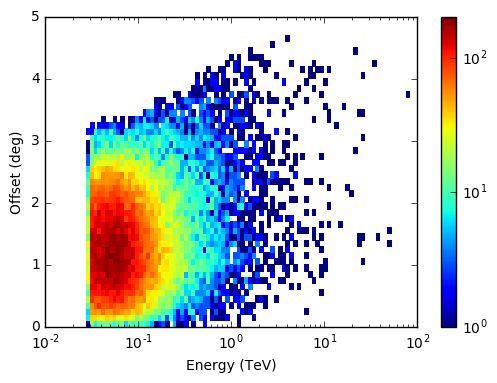

In [24]:
energy_bins = 10 ** np.linspace(-2, 2, 100)
offset_bins = np.arange(0, 5, 0.1)

t = events.table
offset = np.sqrt(t['DETX'] ** 2 + t['DETY'] ** 2)
hist = np.histogram2d(
    x=t['ENERGY'], y=offset,
    bins=(energy_bins, offset_bins),
)[0].T

from matplotlib.colors import LogNorm
plt.pcolormesh(energy_bins, offset_bins,
               hist, norm=LogNorm())
plt.semilogx()
plt.colorbar()
plt.xlabel('Energy (TeV)')
plt.ylabel('Offset (deg)')


So the CTA field of view increases with energy. The energy distribution we saw before was the combination of the energy distribution at all offsets and a mix of gammas and gamma-like event. Even at a single offset, the double energy-threshold at ~ 30 GeV and ~ 100 GeV is present.

### Stacking EVENTS tables

As a final example of how to work with event lists, here's now to apply arbitrary event selections and how to stack events tables from several observations into a single event list.

We will just use astropy.table.Table directly, not go via the gammapy.data.EventList class. Note that you can always make an EventList object from a Table object via event_list = EventList(table). One point to keep in mind is that Table.read doesn't resolve environment variables in filenames, so we'll use the Python standard library os package to construct the filenames.


In [25]:
import os
from astropy.table import Table
from astropy.table import vstack as table_vstack

filename = os.path.join(os.environ['CTADATA'], 'data/gps/obs_110029.fits')
t1 = Table.read(filename, hdu='EVENTS')

filename = os.path.join(os.environ['CTADATA'], 'data/gps/obs_110029.fits')
t2 = Table.read(filename, hdu='EVENTS')
tables = [t1, t2]
table = table_vstack(tables, metadata_conflicts='silent')

In [26]:
print('Number of events: ', len(table))

('Number of events: ', 100088)


In [27]:
# Let's select gamma rays with energy above 10 TeV
mask_mc_id = table['MC_ID'] != 1
mask_energy = table['ENERGY'] > 10
mask = mask_mc_id & mask_energy
table2 = table[mask]
print('Number of events after selection:', len(table2))

('Number of events after selection:', 24)




When processing a lot or all of the simulated events, you would write a for loop, and apply the event selection before putting the table in the list of tables, or you might run out of memory. An example is here.

That's all for EVENTS. You now know what every column in the event table contains, and how to work with event list tables using gammapy.data.EventList and astropy.table.Table.

Just in case that there is some observation parameter in the FITS EVENTS header that you're interested in, you can find the full description of the keys you can access via the events.table.meta dictionary here.

## Instrument response functions (IRFs)

The CTA instrument reponse functions are given as FITS files in the caldb folder.

Note that this is not realistic. Real CTA data at the DL3 level (what we have here, what users get) will mostly likely have per-observation or per-time interval IRFs, and the IRFs will not be stored in a separate CALDB folder, but distributed with the EVENTS (probably in the same file, or at least in the same folder, so that it's together).

For now, the EVENT to IRF association (i.e. which IRF is the right one for given EVENTS) is done by index files. We will discuss those in the next section, but before we do, let's look at the CTA IRFs for one given configuration: South_50h.


In [28]:
!(cd $CTADATA && tree caldb)

caldb
└── data
    └── cta
        └── prod2
            ├── bcf
            │   ├── North_0.5h
            │   │   └── irf_file.fits.gz
            │   ├── North_50h
            │   │   └── irf_file.fits.gz
            │   ├── North_5h
            │   │   └── irf_file.fits.gz
            │   ├── South_0.5h
            │   │   └── irf_file.fits.gz
            │   ├── South_50h
            │   │   └── irf_file.fits.gz
            │   └── South_5h
            │       └── irf_file.fits.gz
            └── caldb.indx

10 directories, 7 files


In [29]:
# Let's look at the content of one of the IRF FITS files.
# IRFs are stored in `BinTable` HDUs in a weird format
# that you don't need to care about because it's implemented in Gammapy
irf_filename = os.path.join(os.environ['CTADATA'], 'caldb/data/cta/prod2/bcf/South_50h/irf_file.fits.gz')
from astropy.io import fits
hdu_list = fits.open(irf_filename)
hdu_list.info()

Filename: /home/bruno/MesProgrammes/gammapy-meudon-tutorial/handson/caldb/data/cta/prod2/bcf/South_50h/irf_file.fits.gz
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       8   ()      
  1  EFFECTIVE AREA  BinTableHDU     55   1R x 6C   [500E, 500E, 45E, 45E, 22500E, 22500E]   
  2  POINT SPREAD FUNCTION  BinTableHDU     68   1R x 10C   [21E, 21E, 2E, 2E, 42E, 42E, 42E, 42E, 42E, 42E]   
  3  ENERGY DISPERSION  BinTableHDU     54   1R x 7C   [500E, 500E, 300E, 300E, 2E, 2E, 300000E]   
  4  BACKGROUND  BinTableHDU     57   1R x 7C   [90E, 90E, 90E, 90E, 21E, 21E, 170100E]   



### Effective area

The effective area is given as a 2-dim array with energy and field of view offset axes.


In [30]:
from gammapy.irf import EffectiveAreaTable2D
aeff = EffectiveAreaTable2D.read(irf_filename, hdu='EFFECTIVE AREA')
print(type(aeff))
print(type(aeff.data))

<class 'gammapy.irf.effective_area.EffectiveAreaTable2D'>
<class 'gammapy.utils.nddata.NDDataArray'>


In [31]:
print(aeff.data)

NDDataArray summary info
energy         : size =   500, min =  0.005 TeV, max = 495.450 TeV
offset         : size =    45, min =  0.050 deg, max =  4.450 deg
Data           : size = 22500, min =  0.000 m2, max = 4067346.500 m2



/home/bruno/MesProgrammes/miniconda2/lib/python2.7/site-packages/astropy/units/quantity.py:966: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)


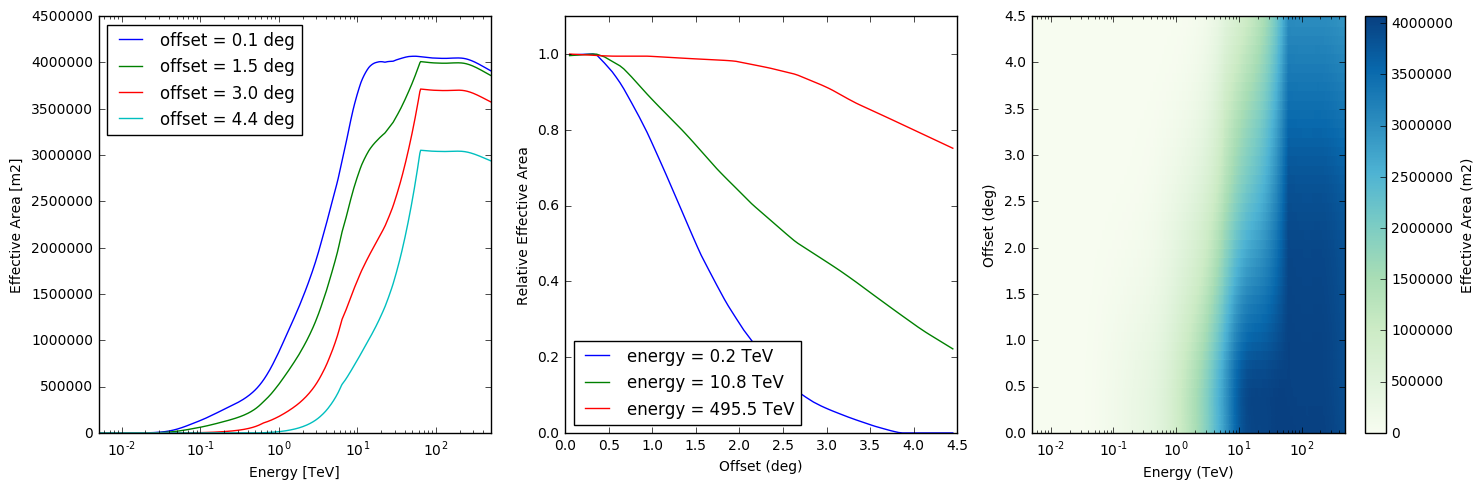

In [32]:
aeff.peek()

In [33]:
# What is the on-axis effective area at 10 TeV?
aeff.data.evaluate(energy='10 TeV', offset='0 deg').to('km2')

<Quantity 3.660645000216057 km2>

In [34]:
# This is how you slice out an `EffectiveAreaTable` object
# at a given field of view offset for analysis
# aeff.to_effective_area_table(offset='1 deg')


### Energy dispersion¶

Let's have a look at the CTA energy dispersion with three axes: true energy, fov offset and migra = e_reco / e_true and has dP / dmigra as value.


In [35]:
from gammapy.irf import EnergyDispersion2D
edisp = EnergyDispersion2D.read(irf_filename, hdu='ENERGY DISPERSION')
print(type(edisp))
print(type(edisp.data))

<class 'gammapy.irf.energy_dispersion.EnergyDispersion2D'>
<class 'gammapy.utils.nddata.NDDataArray'>


In [36]:
print(edisp.data)

NDDataArray summary info
e_true         : size =   500, min =  0.005 TeV, max = 495.450 TeV
migra          : size =   300, min =  0.005, max =  2.995
offset         : size =     2, min =  2.250 deg, max =  6.750 deg
Data           : size = 300000, min =  0.000, max =  0.351



/home/bruno/MesProgrammes/miniconda2/lib/python2.7/site-packages/astropy/units/quantity.py:957: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


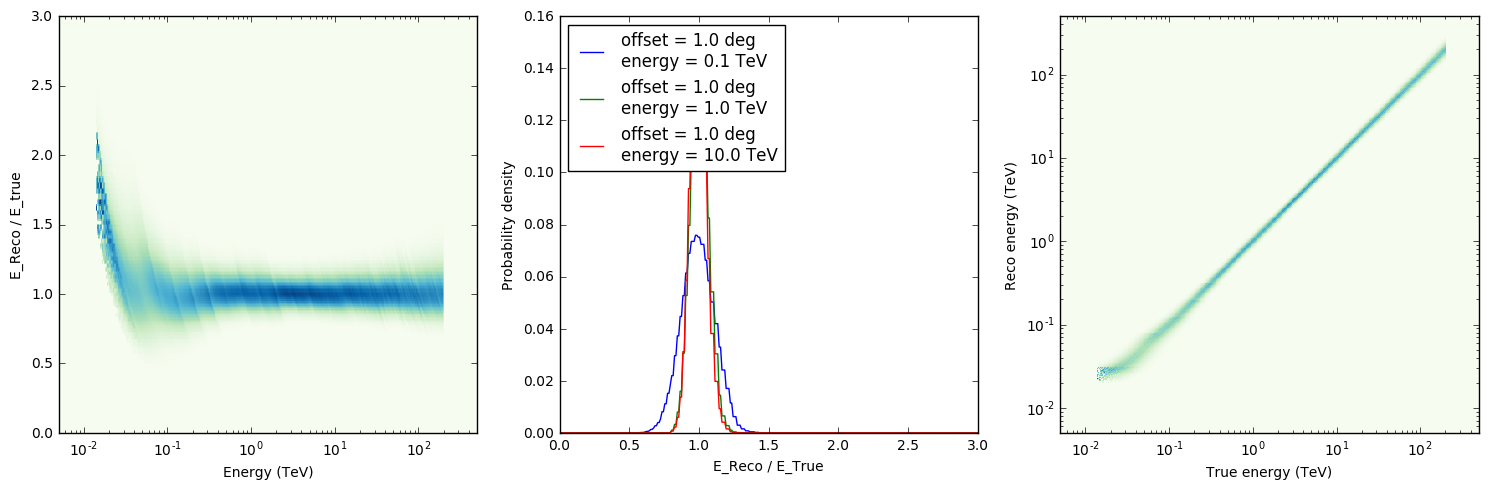

In [37]:
edisp.peek()

Similar to the event energy distribution above, we can see the mixed-telescope array reflected in the EDISP. At low energies the events are only detected and reconstructed by the LSTs. At ~100 GeV, the MSTs take over and EDISP is chaotic in the ~ 50 GeV to 100 GeV energy range. So it can be useful to have quick access to IRFs like with Gammapy (e.g. for spectral line searches in this case), even if for 95% of science analyses users later won't have to look at the IRFs and just trust that everything is working.

In [38]:
# This is how for analysis you could slice out an `EnergyDispersion`
# object at a given offset:
# edisp.to_energy_dispersion(offset='0 deg')


### Point Spread Function


In [39]:
from gammapy.irf import EnergyDependentMultiGaussPSF
psf = EnergyDependentMultiGaussPSF.read(irf_filename, hdu='POINT SPREAD FUNCTION')
print(psf.info())


Summary PSF info
----------------
Theta          : size =     2, min =  0.000 deg, max =  4.500 deg
Energy hi      : size =    21, min =  0.020 TeV, max = 199.526 TeV
Energy lo      : size =    21, min =  0.013 TeV, max = 125.893 TeV
Safe energy threshold lo:  0.100 TeV
Safe energy threshold hi: 100.000 TeV
68% containment radius at theta = 0.0 deg and E =  1.0 TeV: 0.05404825 deg
68% containment radius at theta = 0.0 deg and E = 10.0 TeV: 0.03487985 deg
95% containment radius at theta = 0.0 deg and E =  1.0 TeV: 0.08763720 deg
95% containment radius at theta = 0.0 deg and E = 10.0 TeV: 0.05655636 deg



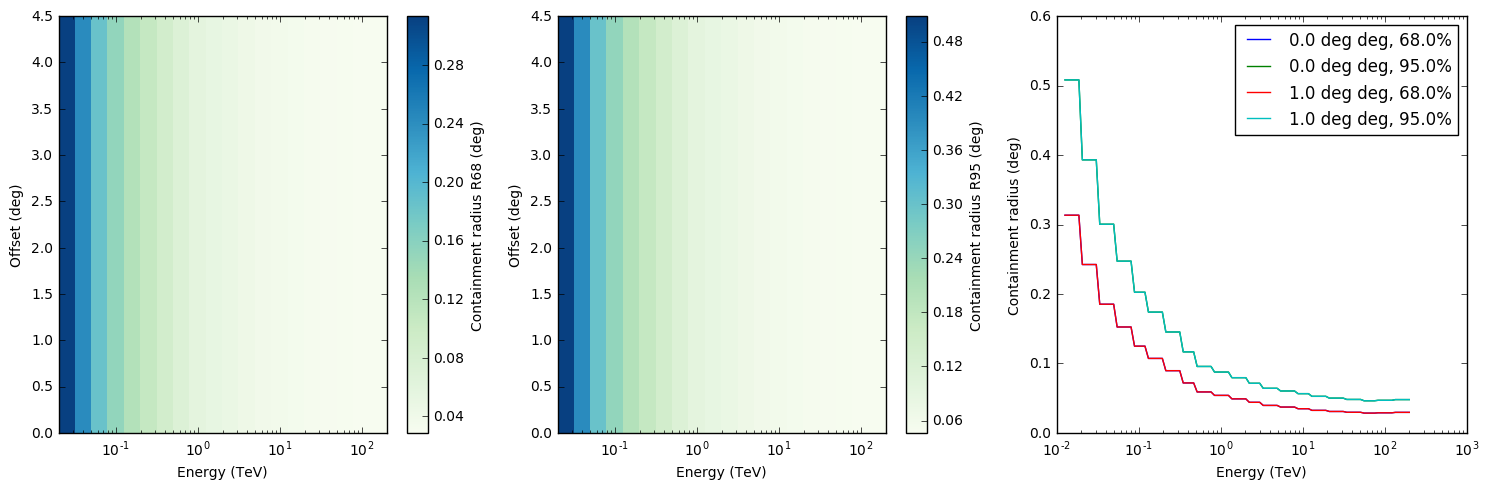

In [40]:
psf.peek()


### Background

We don't support the background 3D format yet. For now you have to estimate the background from the data (using e.g. the reflected background method or the ring background method.

We will add support for it laster this week. Come back soon!


## Index files and DataStore

As we saw, you can access all of the CTA data using Astropy and Gammapy.

But wouldn't it be nice if there were a better, simpler way?

Imagine what life could be like if you had a butler that knows where all the files and HDUs are, and hands you the 1DC data on a silver platter, you just have to ask for it.

Well, the butler exists. He's called gammapy.data.DataStore and he keeps track of the data using index files.

### Index files

The files with in the index folder with names obs-index.fits.gz and hdu-index.fits.gz are so called "observation index files" and "HDU index files".

 - The purpose of observation index files is to get a table of available observations, with the most relevant parameters commonly used for observation selection (e.g. pointing position or observation time). Their format is described in detail here.
 - The purpose of HDU index files is to locate all FITS header data units (HDUs) for a given observation. At the moment, for each observation, there are six relevant HDUs: EVENTS, GTI, AEFF, EDISP, PSF and BKG. The format is described in detail here.

For this tutorial, there is one set of index files per simulated dataset, as well as a set of index files listing all available data in the all directory.

Side comment: if you have data, but no index files, you should write a Python script to make the index files. As an example, the one I used to make the index files for 1DC is here.

In [41]:
!(cd $CTADATA && tree index)

index
├── all
│   ├── hdu-index.fits.gz
│   └── obs-index.fits.gz
└── gps
    ├── hdu-index.fits.gz
    └── obs-index.fits.gz

2 directories, 4 files



### Gammapy DataStore

If you want to access data and IRFs from the CTA simulated mini-GP dataset, just create a DataStore by pointing at a folder where the index files are located.


In [42]:
from gammapy.data import DataStore
data_store = DataStore.from_dir('$CTADATA/index/gps')

In [43]:
# Print out some basic information about the available data:
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /home/bruno/MesProgrammes/gammapy-meudon-tutorial/handson/index/gps
Rows: 738
OBS_ID: 110000 -- 110122
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Number of observations: 123


In [44]:
# The observation index is loaded as a table
print('Number of observations: ', len(data_store.obs_table))
print(data_store.obs_table.colnames)
print('Total observation time (hours): ', data_store.obs_table['ONTIME'].sum() / 3600)

('Number of observations: ', 123)
['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'N_TELS', 'OBJECT', 'CALDB', 'IRF', 'EVENTS_FILENAME', 'EVENT_COUNT']
('Total observation time (hours): ', 61.5)


In [45]:
# The HDU index is loaded as a table
print(len(data_store.hdu_table))
print(data_store.hdu_table.colnames)

738
['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME']


In [46]:
# Of course, you can look at the tables if you like
# data_store.obs_table[:10].show_in_browser(jsviewer=True)
# data_store.hdu_table[:10].show_in_browser(jsviewer=True)


### Select observations¶

With data_store.obs_table you have a table with the most common per-observation parameters that are used for observation selection. Using Python / Table methods it's easy to apply any selection you like, always with the goal of making a list or array of OBS_ID, which is then the input to analysis.

For the current tutorial dataset it's pretty simple, because the only quantities useful for selection are:

 - pointing position
 - which irf (i.e. array / zenith angle)

With real data, there will be more parameters of interest, such as data quality, observation duration, zenith angle, time of observation, ...

Let's look at one example: select observations that are at offset 1 to 2 deg around SNR G284.3-01.8, a TeV source detected by H.E.S.S.


In [48]:
from astropy.coordinates import SkyCoord
table = data_store.obs_table
pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
pos_target = SkyCoord(-76, -1, frame='galactic', unit='deg')
offset = pos_target.separation(pos_obs).deg
mask = (1 < offset) & (offset < 2)
table = table[mask]
print('Number of selected observations: ', len(table))

('Number of selected observations: ', 3)


In [49]:
# Look at the first few
table[['OBS_ID', 'GLON_PNT', 'GLAT_PNT', 'IRF']][:5]

OBS_ID,GLON_PNT,GLAT_PNT,IRF
int64,float64,float64,str9
110030,285.000013354,-1.29999026885,South_50h
110070,284.250005153,-9.85943191128e-06,South_50h
110069,282.750005146,3.54993183602e-05,South_50h


In [50]:
# Check which IRFs were used ... it's all south and 20 deg zenith angle
set(table['IRF'])

{'South_50h'}

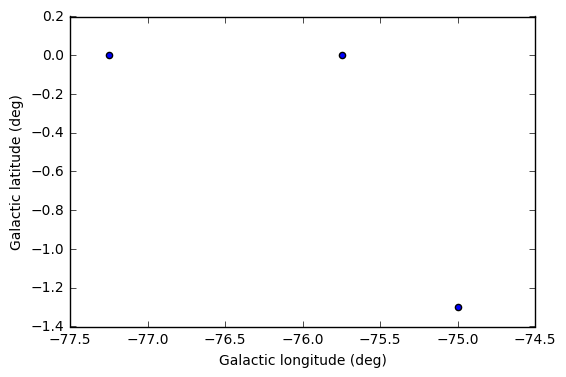

In [51]:
# Check the pointing positions
# The grid pointing positions at GLAT = +- 1.2 deg are visible
from astropy.coordinates import Angle
plt.scatter(Angle(table['GLON_PNT'], unit='deg').wrap_at('180 deg'), table['GLAT_PNT'])
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Galactic latitude (deg)')


### Load data

Once you have selected the observations of interest, use the DataStore to load the data and IRF for those observations. Let's say we're interested in OBS_ID=110115.


In [52]:
obs = data_store.obs(obs_id=110115)

In [53]:
print(obs)

Info for OBS_ID = 110115
- Start time: 663294720.00
- Pointing pos: RA 166.25 deg / Dec -58.77 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 2.000 %



In [54]:
obs.events

In [55]:
obs.events.table[:5]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,663294731.353,165.805,-57.7868,0.0531914,0.980504,-0.238164,2
2,663294836.256,163.698,-58.4261,0.0364688,0.316567,-1.33662,2
3,663294911.616,165.013,-59.4526,0.0514367,-0.690311,-0.629219,2
4,663294924.766,166.976,-61.6706,0.0356527,-2.90434,0.343878,2
5,663295011.925,171.061,-58.3747,0.0471334,0.302999,2.51999,2


In [56]:
obs.aeff

In [57]:
obs.edisp

In [58]:
obs.psf